# History variables for TIGRESS simulation

* Volume average := $$[q]_p \equiv\frac{\sum q \Theta(p)\Delta V}{ \sum \Delta V}$$
* Area average := $$\langle q_k \rangle_p \equiv \frac{\sum_{i,j}q_k\Theta(p)\Delta x \Delta y}{L_x L_y}$$
* $\Theta(p)$ selects just gas within a given phase:
 * phase1: cold (c),              T < 184 K
 * phase2: unstable (u),   184 K <T < 5050 K 
 * phase3: warm (w),       5050 K <T< $2\times10^4$ K
 * phase4: ionized (h1),    2$\times10^4$ K<T<5$\times10^5$ K
 * phase4: hot (h2),        5$\times10^5$ K<T
    
NOTE: Below we use "2p" subscript for sum over c+u+w, i.e. warm-cold ISM

NOTE: averages without phase ("p") subscript are over all phases

NOTE: averages over specific phase or 2p need to be renormalized by volume of phase(s) 


* Default history variables from Athena:
    * time, dt
    * mass / total volume= $[\rho]$
    * totalE = $[E]$
    * x(1/2/3)Mom = $[\rho v_{(1/2/3)}]$
    * x(1/2/3)KE = $[E_{k,(1/2/3)}]=[\rho v_{(1/2/3)}^2/2]$
    * x(1/2/3)ME = $[B_{1/2/3}^2/2]$   NOTE: $B^2$ in Athena = $B_{phys}^2/4\pi$ 
    * gravPE = $[\rho\Phi]$
* Additional TIGRESS history variables:
    * heat_ratio = $[\Gamma/\Gamma_0]$  (ratio of heating rate to fiducial rate)
    * x2dke = $[\delta E_{k,2}]=[\rho (v_2+q\Omega x)^2/2]$  (x2 kinetic energy subtracting out background shear)
    * x(1/2/3)KE_2p = $[\delta E_{k,(1/2/3)}]_{2p}$, where $2p=c+u+w$ (kin. en of warm-cold ISM)
    * F3(h2/h1/w/u/c) = 
    $( \langle (\rho v_3)_{k=ke+1}\rangle_{(h2/h1/w/u/c)} - \langle (\rho v_3)_{k=ks}\rangle_{(h2/h1/w/u/c)})$  (mass flux of each phase out of top plus bottom z-boundary)
    * F3_(upper/lower) = 
    $\langle (\rho v_3)_{k=(ke+1)/ks}\rangle$  (mass flux of out of top or bottom z-boundary)
    * H2 = $[\rho z^2]$  (divide by $[\rho]$ to get square of scale height)
    * H2(h2/h1/w/u/c) = $[\rho z^2]_{(h2/h1/w/u/c)}$ (square of scale height, individual phase)
    * P(_2p) = $[P]_{(2p)}$  (pressure of all (or warm-cold) gas)
    * Pth(_2p) = $ \langle P_{k = kmid-1} + P_{k =kmid}\rangle_{(2p)} /2$, where $kmid= ks+ Nz/2 -1$  (thermal pressure of all (or warm-cold) gas at midplane)
    * Pturb(_2p) = $\langle (\rho v_3^2)_{k = kmid-1} + (\rho v_3^2)_{k =kmid}\rangle_{(2p)}/2$  (vertical turbulent pressure of all (or warm-cold) at midplane) 
    * nmid(_2p) = $\langle \rho_{k = kmid-1} + \rho_{k =kmid}\rangle_{(2p)}/2$ (midplane density of all (or warm-cold) gas)
    * Vmid_2p = $\langle \Theta(2p) \rangle/2$ (midplane volume of warm-cold ISM)
    * V(h2/h1/w/u/c) = $[\Theta(h2/h1/w/u/c)]$ (volume of phase p/ total volume)
    * M(h2/h1/w/u/c) = $[\rho\Theta(h2/h1/w/u/c)]$ (mass of phase p/ total volume)
    * B(1/2/3) = $[B_{i,(1/2/3)}]$ (mean magentic field components)
    * sfr(10/40/100) = $\Sigma_{\rm SFR} (\Delta t =  (10/40/100){\rm Myr})$ (star formation rate/area averaged over last 10, 40 100 Myr)
    * msp = $[M_{\rm sp}/\Delta V]$ if a grid zone (i,j,k) has star particles (mass in sink particles/ total volume)
    * mghost = $[\rho]$ if a grid zone (i,j,k) is in control volume of star particles (gas mass in sink particles/total volume)

# packages to be used
 * matplotlib http://matplotlib.org/
 * numpy
 * pandas http://pandas.pydata.org/
 * astropy http://www.astropy.org/

In [1]:
%matplotlib inline

/tigress/eostrike/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
import sys
sys.path.insert(0,'../')

In [3]:
from pyathena import ath_hst

ath_hst.__file__

'../pyathena/ath_hst.pyc'

In [4]:
ath_hst 

<module 'pyathena.ath_hst' from '../pyathena/ath_hst.pyc'>

# ath_hst.py

* When the code is run, the Athena history dump can be found under the directory "id0/" with an extension ".hst"
* To read the history dump, "ath_hst.py" can be used.
* There are two functions you can use:
    * hst = ath_hst.read(hstfilename)
        * uses standard ascii IO to read in the history dump
        * returns a dictionary with keys corresponding to the history variables listed above
        * using each key, you can retrive a time sequence of data values as a numpy array
    * hst = ath_hst.read_w_pandas(hstfilename,write=True)
        * uses pandas packages to read in the history dump
        * returns pandas DataFrame containing all the information
        * if write=True, it automatically writes the DataFrame to "pickle" format
        * if there is a pickle file with filename = hstfilename + '.p', and the pickle file is newer than the original history file, it automatically reads the "pickle" file, which is much faster than reading the original ascii file
        * the SN history dump can also be accessed with this function

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.constants as c
import astropy.units as u
plt.rcParams['figure.figsize']=8,8
plt.rcParams.update({'font.size': 14})

## TIGRESS simulation output directory must be selected here:

In [6]:
#The following is an example for history files within the /id0 directory, which is the default:
#basedir='/tigress/changgoo/'
#id='MHD_4pc_new'
#hstfilename=basedir+id+'/id0/'+id+'.hst'

In [7]:
#The following is for history files within the hst directory:
basedir='/tigress/changgoo/'
id='MHD_4pc_new'
hstfilename=basedir+id+'/hst/'+id+'.hst'
#SN history file name
snfilename=basedir+id+'/hst/'+id+'.sn'

In [8]:
hstfilename

'/tigress/changgoo/MHD_4pc_new/hst/MHD_4pc_new.hst'

In [9]:
snfilename

'/tigress/changgoo/MHD_4pc_new/hst/MHD_4pc_new.sn'

### Note that there are three "4pc" models
* MHD_4pc: old feedback with standard box size (1024,1024,4096)pc
* MHD_4pc_T2: old feedback with tall box size (1024,1024,8960)pc; use longer and stronger initial turbulence driving
* MHD_4pc_new: new feedback with tall box size (1024,1024,7168)pc

### Read the Athena history dump with ascii IO:

In [10]:
hst=ath_hst.read(hstfilename)

Reading a history file:/tigress/changgoo/MHD_4pc_new/hst/MHD_4pc_new.hst


In [11]:
print hst.keys()

['Vmid_2p', 'F3c', 'vol', 'gravPE', 'F3w', 'Vh1', 'x3KE', 'H2u', 'F3_lower', 'x3ME', 'totalE', 'x3Mom', 'sfr100', 'Mh2', 'x2Mom', 'Mh1', 'F3_upper', 'Pturb_2p', 'Vw', 'nmid_2p', 'Pturb', 'msp', 'mghost', 'x1KE_2p', 'H2h2', 'H2h1', 'nmid', 'x1Mom', 'heat_ratio', 'sfr40', 'B1', 'x1KE', 'Mc', 'x2ME', 'P_2p', 'H2w', 'Pth_2p', 'x2KE', 'Mu', 'P', 'Mw', 'x1ME', 'F3h1', 'F3h2', 'dt', 'Vh2', 'H2c', 'x2dke', 'sfr10', 'Vc', 'x2KE_2p', 'Pth', 'H2', 'B3', 'x3KE_2p', 'mass', 'Vu', 'B2', 'time', 'F3u']


## Unit system

The unit system we choose for this simulation is
* [length] = pc
* [velocity] = km/s
* [density] = 1.4271*m_h/cm^3

In [12]:
#We use set_units from pyathena for units conversions
# This uses units and constants from astropy
from pyathena import set_units
set_units

<function pyathena.set_units.set_units>

In [13]:
unit=set_units(muH=1.4271)
print unit['density'].cgs/1.4271/c.m_p.cgs
print unit['velocity']
print unit['length']
print unit['mass']
print unit['time']
print unit['magnetic_field']

# other units can be easily obtained
print unit.keys()


1.0 1 / cm3
1.0 km / s
1.0 pc
0.0352682242985 solMass
0.977792221673 Myr
0.547685223955 uG
['number_density', 'temperature', 'density', 'magnetic_field', 'pressure', 'length', 'mass', 'time', 'velocity', 'muH', 'gravitational_potential']


In [14]:
#For converting from code units to useful astronomical units
Myr=unit['time'].to('Myr').value
Msun=unit['mass'].to('Msun').value
pok=(unit['pressure']/c.k_B).cgs.value
surf=(unit['density']*unit['length']).to('Msun/pc^2').value

### Plot star formation rate history

Text(0,0.5,'$\\Sigma_{SFR}  [M_\\odot \\ pc^{-2}\\ Myr^{-1}$]')

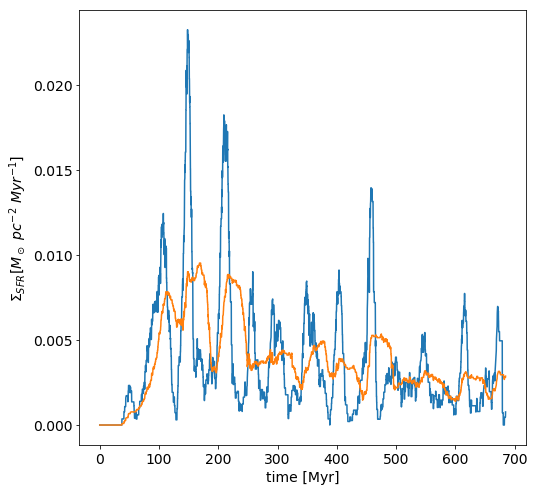

In [15]:
#Note: sfr output by the code is in Msun/pc^2/Myr
#      need to convert time 
plt.plot(hst['time']*Myr,hst['sfr10'])
plt.plot(hst['time']*Myr,hst['sfr40'])
#plt.plot(hst['time']*Myr,hst['sfr100'])
plt.xlabel('time [Myr]')
plt.ylabel('$\Sigma_{SFR}  [M_\odot \ pc^{-2}\ Myr^{-1}$]')

### Midplane pressure history

Text(0,0.5,'P/k [$cm^{-3} K]$')

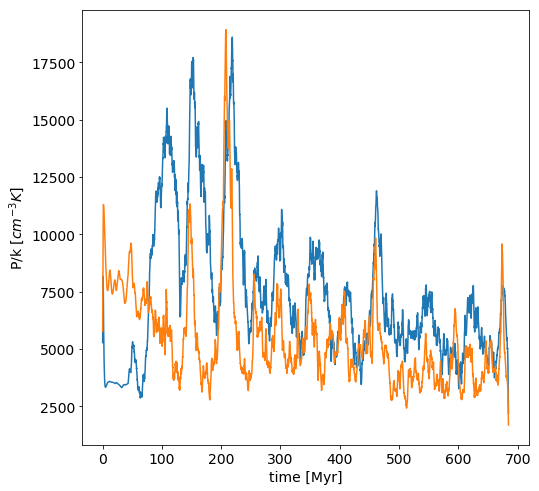

In [16]:
from astropy.convolution import convolve, Box1DKernel
smoothPth=convolve(hst['Pth'],Box1DKernel(20))
smoothPturb=convolve(hst['Pturb'],Box1DKernel(20))
plt.plot(hst['time']*Myr,smoothPth*pok)
plt.plot(hst['time']*Myr,smoothPturb*pok)
plt.xlabel('time [Myr]')
plt.ylabel('P/k [$cm^{-3} K]$')

### Read the Athena history dump with pandas

In [17]:
hstp=ath_hst.read_w_pandas(hstfilename)

Reading a history file:/tigress/changgoo/MHD_4pc_new/hst/MHD_4pc_new.hst.p


In [18]:
hstp[1:10]

,time,dt,mass,totalE,x1Mom,x2Mom,x3Mom,x1KE,x2KE,x3KE,...,Mu,Mc,B1,B2,B3,sfr10,sfr40,sfr100,msp,mghost
1,0.105621,0.009610,0.051455,7.595156,-2.683253e-09,0.000032,5.940351e-09,0.776731,2.576861,0.833737,...,0.000000,0.0,1.022176e-09,0.251635,4.847600e-19,0.0,0.0,0.0,0.0,0.0
2,0.201731,0.009613,0.051455,7.474696,-5.414994e-09,0.000059,1.139693e-08,0.783713,2.583584,0.840712,...,0.000000,0.0,5.272955e-09,0.251632,2.698859e-19,0.0,0.0,0.0,0.0,0.0
3,0.307572,0.009635,0.051455,7.387897,-8.503197e-09,0.000088,1.831912e-08,0.791153,2.590946,0.847950,...,0.000000,0.0,1.646384e-08,0.251627,9.469526e-19,0.0,0.0,0.0,0.0,0.0
4,0.404160,0.009693,0.051455,7.328030,-1.087595e-08,0.000112,2.539763e-08,0.797691,2.597605,0.854125,...,0.001308,0.0,3.490673e-08,0.251622,6.304345e-19,0.0,0.0,0.0,0.0,0.0
5,0.501460,0.009779,0.051455,7.278288,-1.291117e-08,0.000135,3.499797e-08,0.804007,2.604227,0.859902,...,0.017562,0.0,6.233540e-08,0.251617,-1.542810e-19,0.0,0.0,0.0,0.0,0.0
6,0.609611,0.009893,0.051455,7.231047,-1.563424e-08,0.000158,4.717303e-08,0.810669,2.611447,0.865762,...,0.023749,0.0,1.014025e-07,0.251611,-5.140280e-19,0.0,0.0,0.0,0.0,0.0
7,0.708810,0.009956,0.051455,7.192970,-1.807745e-08,0.000177,6.158298e-08,0.816406,2.617897,0.870576,...,0.026899,0.0,1.410212e-07,0.251605,1.421503e-18,0.0,0.0,0.0,0.0,0.0
8,0.808702,0.010032,0.051455,7.158440,-1.918636e-08,0.000192,7.840075e-08,0.821780,2.624178,0.874839,...,0.028986,0.0,1.789726e-07,0.251598,-1.900560e-18,0.0,0.0,0.0,0.0,0.0
9,0.909274,0.010085,0.051455,7.126727,-2.196795e-08,0.000205,9.801636e-08,0.826736,2.630231,0.878495,...,0.030468,0.0,2.094272e-07,0.251592,-2.791942e-18,0.0,0.0,0.0,0.0,0.0


Text(0,0.5,'$\\Sigma_{SFR}  [M_\\odot \\ pc^{-2}\\ Myr^{-1}$]')

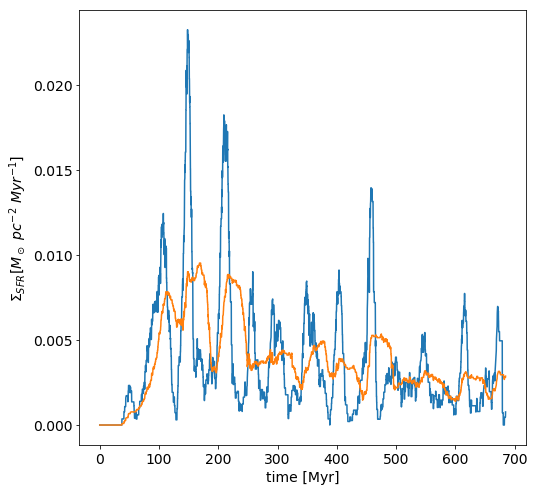

In [19]:
plt.plot(hst['time']*Myr,hst['sfr10'])
plt.plot(hstp.time*Myr,hstp.sfr40)
plt.xlabel('time [Myr]')
plt.ylabel('$\Sigma_{SFR}  [M_\odot \ pc^{-2}\ Myr^{-1}$]')

/tigress/eostrike/miniconda2/lib/python2.7/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


Text(0,0.5,'$\\Sigma_{SFR}  [M_\\odot \\ pc^{-2}\\ Myr^{-1}$]')

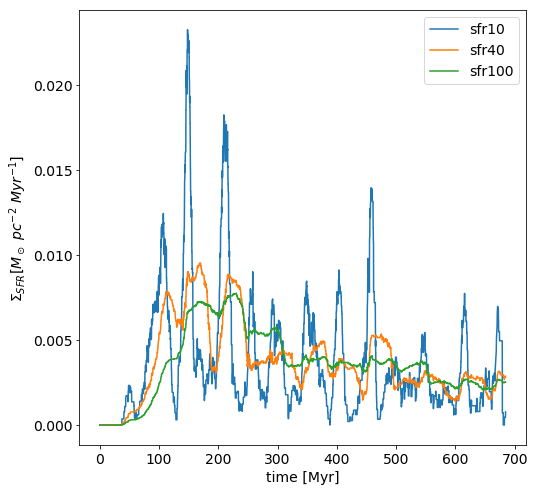

In [20]:
#convert time to Myr in pandas and plot
tMyr=hstp['time']*Myr
hstp['timeMyr']=tMyr
hstp.plot(x=['timeMyr'],y=['sfr10','sfr40','sfr100'])
plt.xlabel('time [Myr]')
plt.ylabel('$\Sigma_{SFR}  [M_\odot \ pc^{-2}\ Myr^{-1}$]')

# Mean densities of each phase from the history dump

Text(0,0.5,'mean density by phase [cm$^{-3}$]')

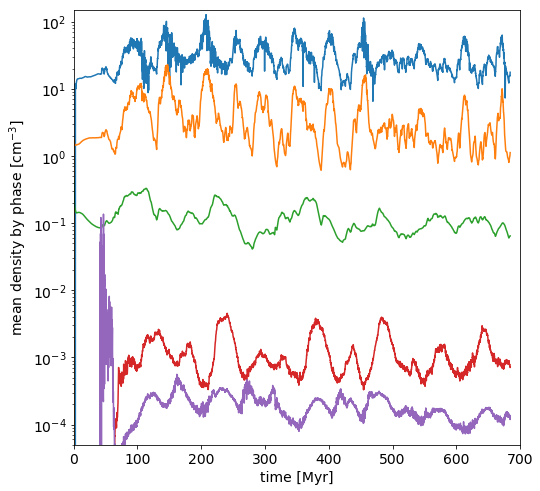

In [21]:
#Mtot=hst['Mc']+ hst['Mu']+ hst['Mw']+hst['Mh1']+hst['Mh2']
Mtot=hst['mass']
plt.plot(hst['time']*Myr,hst['Mc']/(1.e-10+ hst['Vc']))
plt.plot(hst['time']*Myr,hst['Mu']/(1.e-10+ hst['Vu']))
plt.plot(hst['time']*Myr,hst['Mw']/(1.e-10+ hst['Vw']))
plt.plot(hst['time']*Myr,hst['Mh1']/(1.e-10+ hst['Vh1']))
plt.plot(hst['time']*Myr,hst['Mh2']/(1.e-10+ hst['Vh2']))
plt.axis([0,700,5.e-5,150.])
plt.yscale('log')
plt.xlabel('time [Myr]')
plt.ylabel('mean density by phase [cm$^{-3}$]')

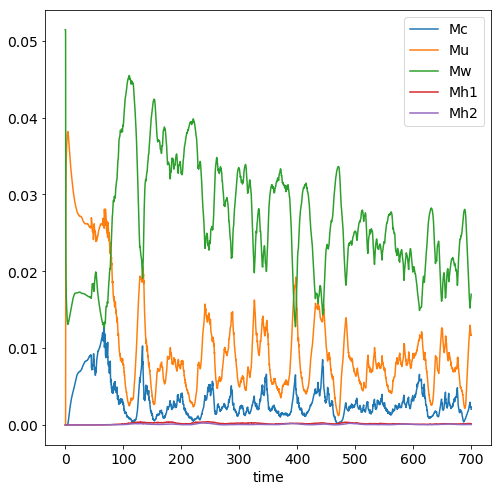

In [22]:
#basic plot of mass of all phases from pandas history 
hstp.plot(x='time',y=['Mc','Mu','Mw','Mh1','Mh2'])

# Mass Fractions from the pandas history data

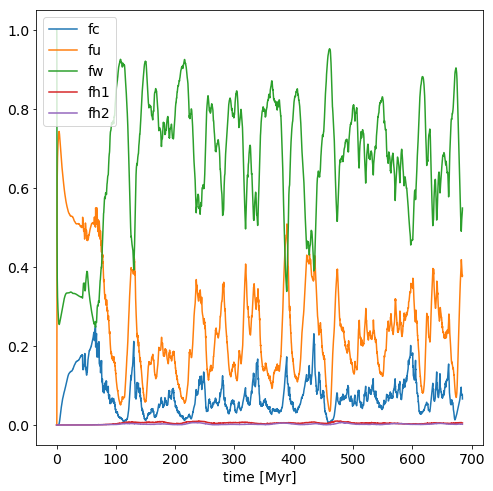

In [23]:
# convert the mean density of each phase to mass fraction using pandas
phase=['c','u','w','h1','h2']
for p in phase:
    hstp['f'+p]=hstp['M'+p]/hstp['mass']
    hstp.plot(x='timeMyr',y='f'+p,ax=plt.gca())
    plt.xlabel('time [Myr]')

# Scale heights

Text(0,0.5,'scale height [pc]')

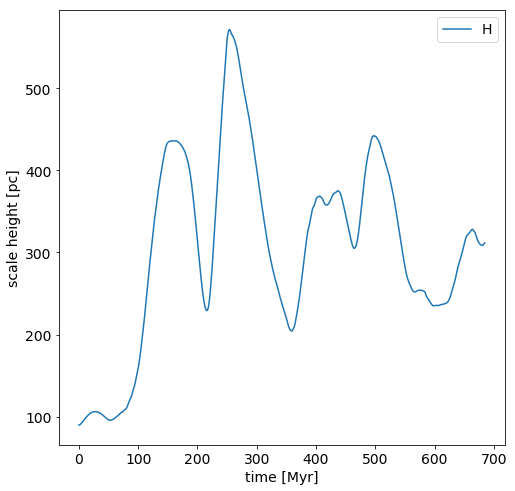

In [24]:
#scale height of the whole medium
hstp['H']=np.sqrt(hstp['H2']/hstp['mass'])
ax=hstp.plot(x='timeMyr',y='H')
ax.set_xlabel(xlabel='time [Myr]')
ax.set_ylabel(ylabel='scale height [pc]')

Text(0,0.5,'scale height [pc]')

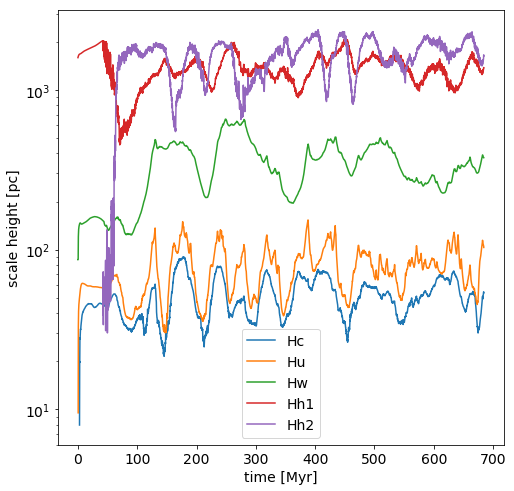

In [25]:
#scale heights of individual phases
phase=['c','u','w','h1','h2']
for p in phase:
    hstp['H'+p]=np.sqrt(hstp['H2'+p]/hstp['M'+p])
    hstp.plot(x='timeMyr',y='H'+p,ax=plt.gca())
plt.yscale('log')
plt.xlabel('time [Myr]')
plt.ylabel('scale height [pc]')

### Velocity Dispersions

Text(0,0.5,'$\\sigma$ [km/s]')

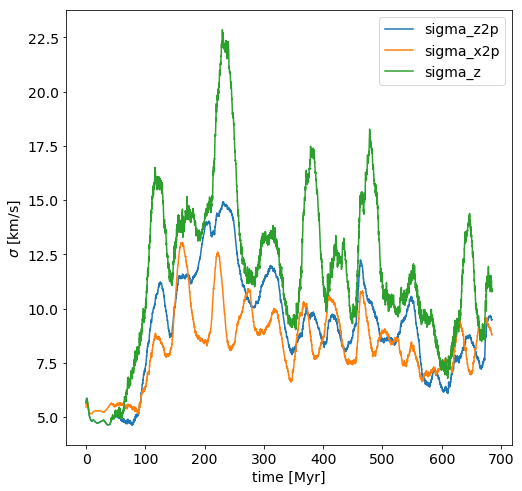

In [26]:
#mass of the warm-cold medium
hstp['M_2p']=hstp['Mc']+hstp['Mu']+hstp['Mw']
#velocity dispersions of the warm-cold medium
hstp['sigma_z2p']=np.sqrt(2.0*hstp['x3KE_2p']/hstp['M_2p'])
hstp['sigma_x2p']=np.sqrt(2.0*hstp['x1KE_2p']/hstp['M_2p'])
#velocity dispersion of whole medium
hstp['sigma_z']=np.sqrt(2.0*hstp['x3KE']/hstp['mass'])
ax=hstp.plot(x='timeMyr',y='sigma_z2p')
hstp.plot(x='timeMyr',y='sigma_x2p',ax=plt.gca())
hstp.plot(x='timeMyr',y='sigma_z',ax=plt.gca())
ax.set_xlabel(xlabel='time [Myr]')
ax.set_ylabel(ylabel='$\sigma$ [km/s]')

# SN data
* id = id of the host star particle
* time = time of explosion
* age = age of the host star particle; for runaway, this is just indicator of clock. SN exploded as age exceeds zero
* mage = mass-weighted age of the host star particle; for runaway, this is time since runaway creation
* mass = mass of the host star particle. can be used to distinguish runaways
* (x1/x2/x3) = position of the host star particle
* (x1sn/x2sn/x3sn) = position of SN explosion; now it is identical to the star particle position, but possibly we can add a distribution of SN locations wrt from the star particle
* (n/v1/v2/v3/e)avg = mean gas properties within SNR (initial feedback region for SN)
* vol = volume of SNR
* radius = radius of SNR
* SFUV = $\Sigma_{\rm FUV}$ for the host star particle
* SNRate = SN rate calculated based on the host star particle properties
* SNprob = randomly generated probability; this should be smaller than SNRate for explosion
* runaway = 1 if SN from runaway
* parent = parent star cluster id of the runaway
* mode = SN feedback type
* active = active flag of the host star particle
* fm = mass within the SNR/M_sf, where M_sf is predicted based on navg.  

In [27]:
# read SN file with pandas
#sn=ath_hst.read_w_pandas(hstfilename.replace('.hst','.sn'))
# read SN file with ascii IO
#sn=ath_hst.read(snfilename)
varlist=ath_hst.get_varlist(snfilename)
sn=pd.read_table(snfilename,skiprows=1,names=varlist,sep='\s*',comment='#')

/tigress/eostrike/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


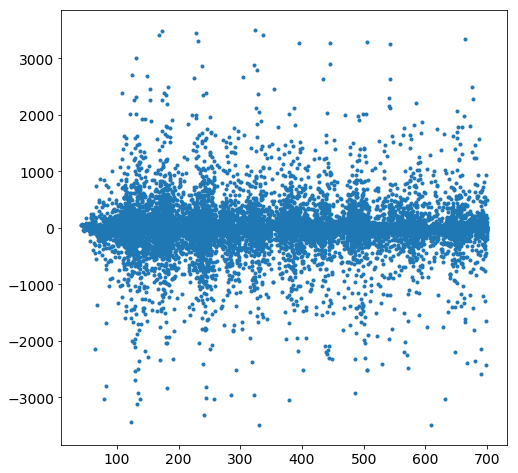

In [28]:
#vertical locations of SN events
plt.plot(sn['time'],sn['x3'],'.')

In [29]:
runaway=sn['mass'] == 0.0
rsn=sn[runaway]
csn=sn[~runaway]

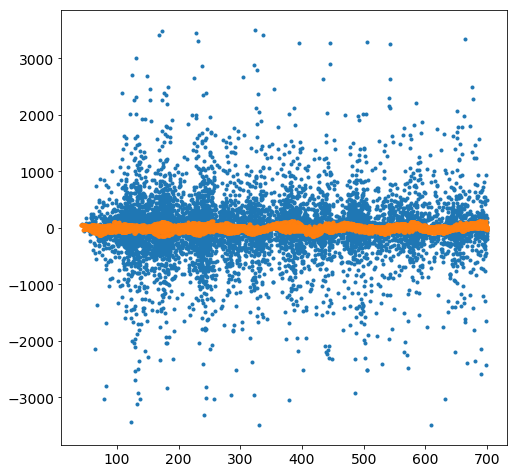

In [30]:
#plot vertical locations of runaway (blue) and cluster (orange) SNe
plt.plot(rsn['time'],rsn['x3'],'.')
plt.plot(csn['time'],csn['x3'],'.')